In [ ]:
import pandas as pd
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving 2013.csv to 2013.csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

User uploaded file "2013.csv" with length 97297942 bytes


In [ ]:
uploaded

In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['2013.csv'].decode('utf-8')))
print(df)

            FL_DATE OP_CARRIER  ...  SECURITY_DELAY LATE_AIRCRAFT_DELAY
0        01/01/2013         VX  ...             NaN                 NaN
1        01/01/2013         VX  ...             NaN                 NaN
2        01/01/2013         VX  ...             NaN                 NaN
3        01/01/2013         VX  ...             NaN                 NaN
4        01/01/2013         VX  ...             NaN                 NaN
...             ...        ...  ...             ...                 ...
1048570  05/03/2013         WN  ...             NaN                 NaN
1048571  05/03/2013         WN  ...             NaN                 NaN
1048572  05/03/2013         WN  ...             NaN                 NaN
1048573  05/03/2013         WN  ...             NaN                 NaN
1048574  05/03/2013         WN  ...             NaN                 NaN

[1048575 rows x 27 columns]


In [ ]:
df.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 18878
DEP_DELAY                18878
TAXI_OUT                 19402
WHEELS_OFF               19402
WHEELS_ON                20173
TAXI_IN                  20173
CRS_ARR_TIME                 0
ARR_TIME                 20173
ARR_DELAY                21741
CANCELLED                    0
CANCELLATION_CODE      1028912
DIVERTED                     0
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME      21741
AIR_TIME                 21741
DISTANCE                     0
CARRIER_DELAY           864564
WEATHER_DELAY           864564
NAS_DELAY               864564
SECURITY_DELAY          864564
LATE_AIRCRAFT_DELAY     864564
dtype: int64

In [ ]:
imputation_mean = df.copy()
imputation_mean['CRS_DEP_TIME_Mean'] = imputation_mean['CRS_DEP_TIME'].fillna(df['CRS_DEP_TIME'].mean())
imputation_mean['DEP_TIME'] = imputation_mean['DEP_TIME'].fillna(df['DEP_TIME'].mean())
imputation_mean['CRS_ARR_TIME_Mean'] = imputation_mean['CRS_ARR_TIME'].fillna(df['CRS_ARR_TIME'].mean())
imputation_mean['ARR_TIME'] = imputation_mean['ARR_TIME'].fillna(df['ARR_TIME'].mean())
imputation_mean['ACTUAL_ELAPSED_TIME_Mean'] = imputation_mean['ACTUAL_ELAPSED_TIME'].fillna(df['ACTUAL_ELAPSED_TIME'].mean())
imputation_mean['CRS_ELAPSED_TIME'] = imputation_mean['CRS_ELAPSED_TIME'].fillna(df['CRS_ELAPSED_TIME'].mean())

In [ ]:
anomaly1 = imputation_mean[["CRS_DEP_TIME_Mean","DEP_TIME"]]
anomaly2 = imputation_mean[["CRS_ARR_TIME_Mean","ARR_TIME"]]
anomaly3 = imputation_mean[["CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME_Mean"]]

In [ ]:
anomaly1

,CRS_DEP_TIME_Mean,DEP_TIME
0,700,700.0
1,2205,2204.0
2,730,729.0
3,700,700.0
4,1100,1104.0
...,...,...
1048570,1945,1951.0
1048571,715,713.0
1048572,1345,1340.0
1048573,1655,1714.0


In [ ]:
anomaly2

,CRS_ARR_TIME_Mean,ARR_TIME
0,1445,1418.0
1,545,536.0
2,1115,1049.0
3,1000,1014.0
4,1915,1837.0
...,...,...
1048570,2015,2009.0
1048571,930,933.0
1048572,1555,1543.0
1048573,1905,1919.0


In [ ]:
anomaly3

,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME_Mean
0,285,258.0
1,280,272.0
2,405,380.0
3,360,374.0
4,315,273.0
...,...,...
1048570,90,78.0
1048571,135,140.0
1048572,130,123.0
1048573,130,125.0


In [ ]:
detection1 = anomaly1
detection2 = anomaly2
detection3 = anomaly3

In [ ]:
detection1.isnull().sum()

CRS_DEP_TIME_Mean    0
DEP_TIME             0
dtype: int64

In [ ]:
detection2.isnull().sum()

CRS_ARR_TIME_Mean    0
ARR_TIME             0
dtype: int64

In [ ]:
detection3.isnull().sum()

CRS_ELAPSED_TIME            0
ACTUAL_ELAPSED_TIME_Mean    0
dtype: int64

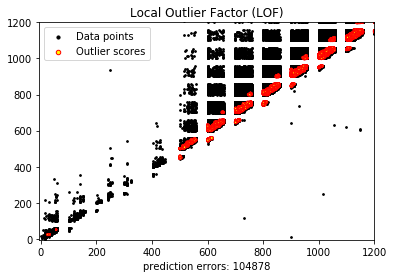

In [ ]:
#LOF#detection1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(detection1), dtype=int)
ground_truth[-n_outliers:] = -1


clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
detection1['anomaly'] = clf.fit_predict(detection1)
detection1['anomaly'] = detection1['anomaly'].map( {1: 0, -1: 1} )
detection1['anomaly'].value_counts()
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(detection1.iloc[:, 0], detection1.iloc[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(detection1.iloc[:, 0], detection1.iloc[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='yellow', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

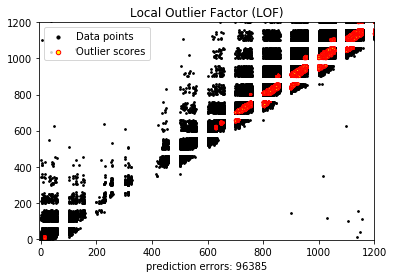

In [ ]:
#LOF#detection2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(detection2), dtype=int)
ground_truth[-n_outliers:] = -1


clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
detection2['anomaly'] = clf.fit_predict(detection2)
detection2['anomaly'] = detection2['anomaly'].map( {1: 0, -1: 1} )
detection2['anomaly'].value_counts()
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(detection2.iloc[:, 0], detection2.iloc[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(detection2.iloc[:, 0], detection2.iloc[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='yellow', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

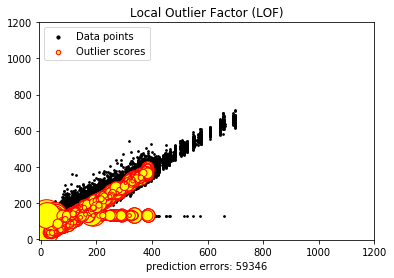

In [ ]:
#LOF#detection3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor


np.random.seed(42)

X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(detection3), dtype=int)
ground_truth[-n_outliers:] = -1


clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
detection3['anomaly'] = clf.fit_predict(detection3)
detection3['anomaly'] = detection3['anomaly'].map( {1: 0, -1: 1} )
detection3['anomaly'].value_counts()
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(detection3.iloc[:, 0], detection3.iloc[:, 1], color='k', s=3., label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(detection3.iloc[:, 0], detection3.iloc[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='yellow', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [ ]:
p1 = (detection1['DEP_TIME'] >= detection1['DEP_TIME'].quantile(0.98)) 
p2 = (detection1['CRS_DEP_TIME_Mean'] >= detection1['CRS_DEP_TIME_Mean'].quantile(0.98))
p3 = (detection2['ARR_TIME'] >= detection2['ARR_TIME'].quantile(0.98)) 
p4 = (detection2['CRS_ARR_TIME_Mean'] >= detection2['CRS_ARR_TIME_Mean'].quantile(0.98))
p5 = (detection3['ACTUAL_ELAPSED_TIME_Mean'] >= detection3['ACTUAL_ELAPSED_TIME_Mean'].quantile(0.98)) 
p6 = (detection3['CRS_ELAPSED_TIME'] >= detection3['CRS_ELAPSED_TIME'].quantile(0.98))

In [ ]:
import numpy as np
detection1['anomaly_manual'] = (p1 | p2).astype(np.int)
detection2['anomaly_manual'] = (p3 | p4).astype(np.int)
detection3['anomaly_manual'] = (p5 | p6).astype(np.int)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix,precision_score
def get_sensitivity_specificity(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    sensitivity = cf[0,0]/(cf[:,0].sum())
    specificity = cf[1,1]/(cf[:,1].sum())
    return sensitivity, specificity

In [ ]:
f1_lof = f1_score(detection1['anomaly_manual'],detection1['anomaly'])
acc_lof = accuracy_score(detection1['anomaly_manual'],detection1['anomaly'])
pre_lof = precision_score(detection1['anomaly_manual'],detection1['anomaly'])
roc_lof = roc_auc_score(detection1['anomaly_manual'],detection1['anomaly'])
sen_lof, spec_lof = get_sensitivity_specificity(detection1['anomaly_manual'],detection1['anomaly'])
met_lof = {
           'f1_score': f1_lof,
           'accuracy': acc_lof,
           'precision_score': pre_lof,
           'roc_score': roc_lof,
           'sensitivity': sen_lof,
           'specificity': spec_lof
          }
  
f1_lof = f1_score(detection2['anomaly_manual'],detection2['anomaly'])
acc_lof = accuracy_score(detection2['anomaly_manual'],detection2['anomaly'])
pre_lof = precision_score(detection2['anomaly_manual'],detection2['anomaly'])
roc_lof = roc_auc_score(detection2['anomaly_manual'],detection2['anomaly'])
sen_sen_lof, spec_lof = get_sensitivity_specificity(detection2['anomaly_manual'],detection2['anomaly'])
met_lof2 = {
           'f1_score': f1_lof,
           'accuracy': acc_lof,
           'precision_score': pre_lof,
           'roc_score': roc_lof,
           'sensitivity': sen_lof,
           'specificity': spec_lof
          }

f1_lof = f1_score(detection3['anomaly_manual'],detection3['anomaly'])
acc_lof = accuracy_score(detection3['anomaly_manual'],detection3['anomaly'])
pre_lof = precision_score(detection3['anomaly_manual'],detection3['anomaly'])
roc_lof = roc_auc_score(detection3['anomaly_manual'],detection3['anomaly'])
sen_sen_lof, spec_lof = get_sensitivity_specificity(detection3['anomaly_manual'],detection3['anomaly'])
met_lof3 = {
           'f1_score': f1_lof,
           'accuracy': acc_lof,
           'precision_score': pre_lof,
           'roc_score': roc_lof,
           'sensitivity': sen_lof,
           'specificity': spec_lof
          }

In [ ]:
metrics = {'detection1': met_lof,
           'detection2': met_lof2,
           'detection3': met_lof3
           }
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

,detection1,detection2,detection3
f1_score,0.069258,0.029172,0.262537
accuracy,0.883064,0.883648,0.941183
precision_score,0.043508,0.019030,0.184725
roc_score,0.535761,0.484876,0.703160
sensitivity,0.976346,0.976346,0.976346
specificity,0.043508,0.019030,0.184725


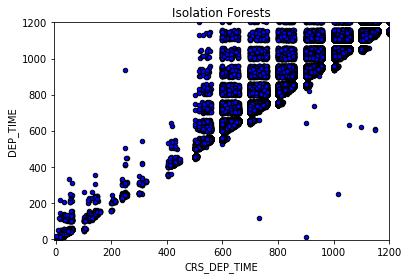

In [ ]:
#isolation forest#detection1
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
outlier_fraction = 0.028

model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=0.25, contamination=outlier_fraction)
model.fit(detection1)
detection1['anomaly_isolated'] = pd.Series(model.predict(detection1))
detection1['anomaly_isolated'] = detection1['anomaly_isolated'].map( {1: 0, -1: 1} )
detection1['anomaly_isolated'].value_counts()

cmap=np.array(['blue','green'])
plt.scatter(detection1.iloc[:,0],detection1.iloc[:,1],c='blue',s=20,edgecolor='k')
X=if_anomalies.iloc[:,0]
Y=if_anomalies.iloc[:,1]
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.scatter(X,Y,c='green')
plt.xlabel('CRS_DEP_TIME')
plt.ylabel('DEP_TIME')
plt.title('Isolation Forests')
plt.show()

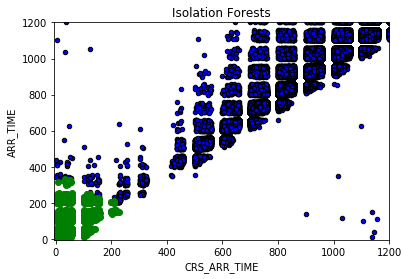

In [ ]:
#isolation forest #detection2
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
outlier_fraction = 0.028

model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=0.25, contamination=outlier_fraction)
model.fit(detection2)
detection2['anomaly_isolated'] = pd.Series(model.predict(detection2))
detection2['anomaly_isolated'] = detection2['anomaly_isolated'].map( {1: 0, -1: 1} )
detection2['anomaly_isolated'].value_counts()

cmap=np.array(['blue','green'])
plt.scatter(detection2.iloc[:,0],detection2.iloc[:,1],c='blue',s=20,edgecolor='k')
X=if_anomalies.iloc[:,0]
Y=if_anomalies.iloc[:,1]
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.scatter(X,Y,c='green')
plt.xlabel('CRS_ARR_TIME')
plt.ylabel('ARR_TIME')
plt.title('Isolation Forests')
plt.show()

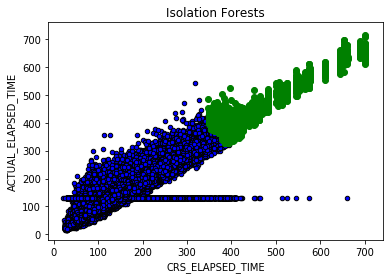

In [ ]:
#isolation forest #detection3
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

outlier_fraction = 0.028

model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=0.25, contamination=outlier_fraction)
model.fit(detection3)
detection3['anomaly_isolated'] = pd.Series(model.predict(detection3))
detection3['anomaly_isolated'] = detection3['anomaly_isolated'].map( {1: 0, -1: 1} )
detection3['anomaly_isolated'].value_counts()

cmap=np.array(['blue','green'])
plt.scatter(detection3.iloc[:,0],detection3.iloc[:,1],c='blue',s=20,edgecolor='k')
X=if_anomalies.iloc[:,0]
Y=if_anomalies.iloc[:,1]
plt.scatter(X,Y,c='green')
plt.xlabel('CRS_ELAPSED_TIME')
plt.ylabel('ACTUAL_ELAPSED_TIME')
plt.title('Isolation Forests')
plt.show()

In [ ]:
i1 = (detection1['DEP_TIME'] >= detection1['DEP_TIME'].quantile(0.98)) 
i2 = (detection1['CRS_DEP_TIME_Mean'] >= detection1['CRS_DEP_TIME_Mean'].quantile(0.98))
i3 = (detection2['ARR_TIME'] >= detection2['ARR_TIME'].quantile(0.98)) 
i4 = (detection2['CRS_ARR_TIME_Mean'] >= detection2['CRS_ARR_TIME_Mean'].quantile(0.98))
i5 = (detection3['ACTUAL_ELAPSED_TIME_Mean'] >= detection3['ACTUAL_ELAPSED_TIME_Mean'].quantile(0.98)) 
i6 = (detection3['CRS_ELAPSED_TIME'] >= detection3['CRS_ELAPSED_TIME'].quantile(0.98))

detection1['anomaly_manual'] = (i1 | i2).astype(np.int)
detection2['anomaly_manual'] = (i3 | i4).astype(np.int)
detection3['anomaly_manual'] = (i5 | i6).astype(np.int)

In [ ]:


f1_iso = f1_score(detection1['anomaly_manual'],detection1['anomaly_isolated'])
acc_iso = accuracy_score(detection1['anomaly_manual'],detection1['anomaly_isolated'])
roc_iso = roc_auc_score(detection1['anomaly_manual'],detection1['anomaly_isolated'])
pre_iso = precision_score(detection1['anomaly_manual'],detection1['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(detection1['anomaly_manual'],detection1['anomaly_isolated'])
met_iso = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'precision':pre_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
}

f1_iso = f1_score(detection2['anomaly_manual'],detection2['anomaly_isolated'])
acc_iso = accuracy_score(detection2['anomaly_manual'],detection2['anomaly_isolated'])
roc_iso = roc_auc_score(detection2['anomaly_manual'],detection2['anomaly_isolated'])
pre_iso = precision_score(detection2['anomaly_manual'],detection2['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(detection2['anomaly_manual'],detection2['anomaly_isolated'])
met_iso2 = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'precision':pre_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
}

f1_iso = f1_score(detection3['anomaly_manual'],detection3['anomaly_isolated'])
acc_iso = accuracy_score(detection3['anomaly_manual'],detection3['anomaly_isolated'])
roc_iso = roc_auc_score(detection3['anomaly_manual'],detection3['anomaly_isolated'])
pre_iso = precision_score(detection3['anomaly_manual'],detection3['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(detection3['anomaly_manual'],detection3['anomaly_isolated'])
met_iso3 = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'precision':pre_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
}

In [ ]:
metrics = {'detection1': met_iso,
           'detection2': met_iso2,
           'detection3': met_iso3
          }
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

,detection1,detection2,detection3
f1_score,0.700056,0.309290,0.831923
accuracy,0.983522,0.960484,0.991342
precision,0.688415,0.316028,0.765293
roc_score,0.851576,0.641555,0.952266
sensitivity,0.992002,0.979046,0.997853
specificity,0.688415,0.316028,0.765293


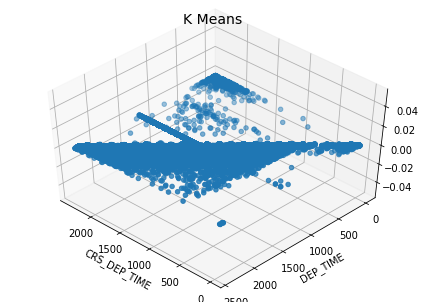

In [ ]:
#kmeans#detection1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D



kFit = KMeans(n_clusters=10).fit(detection1)
kFit.predict(detection1)
label = kFit.labels_

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134, )
ax.scatter(detection1.iloc[:,0], detection1.iloc[:,1])
ax.set_xlabel("CRS_DEP_TIME")
ax.set_ylabel("DEP_TIME")
plt.title("K Means", fontsize=14)
plt.show()

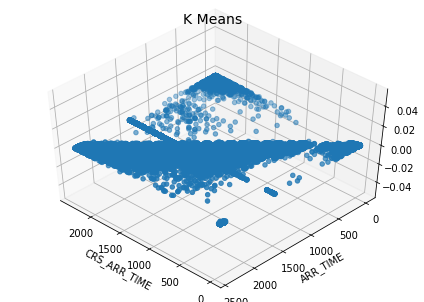

In [ ]:
#kmeans#detection2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D



kFit = KMeans(n_clusters=10).fit(detection2)
kFit.predict(detection2)
label = kFit.labels_

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(detection2.iloc[:,0], detection2.iloc[:,1])
ax.set_xlabel("CRS_ARR_TIME")
ax.set_ylabel("ARR_TIME")
plt.title("K Means", fontsize=14)
plt.show()

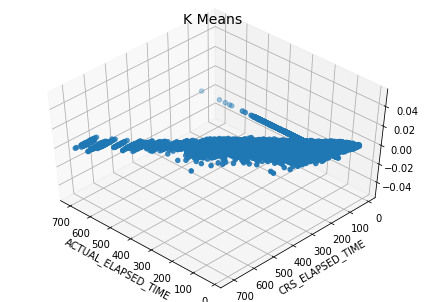

In [ ]:
#kmeans#detection3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D



kFit = KMeans(n_clusters=10).fit(detection3)
kFit.predict(detection3)
label = kFit.labels_

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(detection3.iloc[:,0], detection3.iloc[:,1])
ax.set_xlabel("ACTUAL_ELAPSED_TIME")
ax.set_ylabel("CRS_ELAPSED_TIME")
plt.title("K Means", fontsize=14)
plt.show()

In [ ]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i).fit(detection1) for i in n_cluster]
scores = [kmeans[i].score(detection1) for i in range(len(kmeans))]
cluster_model = kmeans[5]
detection1['cluster'] = cluster_model.predict(detection1)
detection1['cluster'].value_counts()
centers = cluster_model.cluster_centers_
points = np.asarray(detection1)
total_distance = pd.Series()

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i).fit(detection2) for i in n_cluster]
scores = [kmeans[i].score(detection2) for i in range(len(kmeans))]
cluster_model = kmeans[5]
detection2['cluster'] = cluster_model.predict(detection2)
detection2['cluster'].value_counts()
centers = cluster_model.cluster_centers_
points = np.asarray(detection2)
total_distance = pd.Series()

n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i).fit(detection3) for i in n_cluster]
scores = [kmeans[i].score(detection3) for i in range(len(kmeans))]
cluster_model = kmeans[5]
detection3['cluster'] = cluster_model.predict(detection3)
detection3['cluster'].value_counts()
centers = cluster_model.cluster_centers_
points = np.asarray(detection3)
total_distance = pd.Series()

In [ ]:
def get_sum_square_distance(detection1, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(detection1)
    total_distance = pd.Series()
    for i in range(len(points)):
        distance = 0
    
    return total_distance

def get_sum_square_distance(detection1, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(detection2)
    total_distance = pd.Series()
    for i in range(len(points)):
        distance = 0
    
    return total_distance

def get_sum_square_distance(detection1, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(detection3)
    total_distance = pd.Series()
    for i in range(len(points)):
        distance = 0
    
    return total_distance



In [ ]:
detection1['ssd'] = get_sum_square_distance(detection1, cluster_model)
detection2['ssd'] = get_sum_square_distance(detection2, cluster_model)
detection3['ssd'] = get_sum_square_distance(detection3, cluster_model)
cutoff = 6
cutoff = 6

detection1['anomaly'] = (detection1['ssd'] >= cutoff).astype(int)
detection2['anomaly'] = (detection2['ssd'] >= cutoff).astype(int)
detection3['anomaly'] = (detection3['ssd'] >= cutoff).astype(int)

In [ ]:
k1 = (detection1['DEP_TIME'] >= detection1['DEP_TIME'].quantile(0.98)) 
k2 = (detection1['CRS_DEP_TIME_Mean'] >= detection1['CRS_DEP_TIME_Mean'].quantile(0.98))
k3 = (detection2['ARR_TIME'] >= detection2['ARR_TIME'].quantile(0.98)) 
k4 = (detection2['CRS_ARR_TIME_Mean'] >= detection2['CRS_ARR_TIME_Mean'].quantile(0.98))
k5 = (detection3['ACTUAL_ELAPSED_TIME_Mean'] >= detection3['ACTUAL_ELAPSED_TIME_Mean'].quantile(0.98)) 
k6 = (detection3['CRS_ELAPSED_TIME'] >= detection3['CRS_ELAPSED_TIME'].quantile(0.98))

detection1['anomaly_manual'] = (k1 | k2).astype(np.int)
detection2['anomaly_manual'] = (k3 | k4).astype(np.int)
detection3['anomaly_manual'] = (k5 | k6).astype(np.int)

In [ ]:
f1_kmeans = f1_score(detection1['anomaly_manual'],detection1['anomaly'],average='macro')
acc_kmeans = accuracy_score(detection1['anomaly_manual'],detection1['anomaly'])
pre_kmeans = precision_score(detection1['anomaly_manual'],detection1['anomaly'],average='macro')
roc_kmeans = roc_auc_score(detection1['anomaly_manual'],detection1['anomaly'],average='macro')
sen_kmeans, spec_kmeans = get_sensitivity_specificity(detection1['anomaly_manual'],detection1['anomaly'])
met_kmeans = {
           'f1_score': f1_kmeans,
           'accuracy': acc_kmeans,
           'precision_score': pre_kmeans,
           'roc_score': roc_kmeans,
           'sensitivity': sen_kmeans
          }

f1_kmeans = f1_score(detection2['anomaly_manual'],detection2['anomaly'], average='macro')
acc_kmeans = accuracy_score(detection2['anomaly_manual'],detection2['anomaly'])
pre_kmeans = precision_score(detection2['anomaly_manual'],detection2['anomaly'], average='macro')
roc_kmeans = roc_auc_score(detection2['anomaly_manual'],detection2['anomaly'], average='macro')
sen_kmeans, spec_kmeans = get_sensitivity_specificity(detection2['anomaly_manual'],detection2['anomaly'])
met_kmeans2 = {
           'f1_score': f1_kmeans,
           'accuracy': acc_kmeans,
           'precision_score': pre_kmeans,
           'roc_score': roc_kmeans,
           'sensitivity': sen_kmeans
          }
f1_kmeans = f1_score(detection3['anomaly_manual'],detection3['anomaly'], average='macro')
acc_kmeans = accuracy_score(detection3['anomaly_manual'],detection3['anomaly'])
pre_kmeans = precision_score(detection3['anomaly_manual'],detection3['anomaly'], average='macro')
roc_kmeans = roc_auc_score(detection3['anomaly_manual'],detection3['anomaly'], average='macro')
sen_kmeans, spec_kmeans = get_sensitivity_specificity(detection3['anomaly_manual'],detection3['anomaly'])
met_kmeans3 = {
           'f1_score': f1_kmeans,
           'accuracy': acc_kmeans,
           'precision_score': pre_kmeans,
           'roc_score': roc_kmeans,
           'sensitivity': sen_kmeans
          }

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.

In [ ]:
metrics = {'detection1': met_kmeans,
           'detection2': met_kmeans2,
           'detection3': met_kmeans3
           }
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

,detection1,detection2,detection3
f1_score,0.493507,0.492904,0.494163
accuracy,0.974360,0.972012,0.976920
precision_score,0.487180,0.486006,0.488460
roc_score,0.500000,0.500000,0.500000
sensitivity,0.974360,0.972012,0.976920


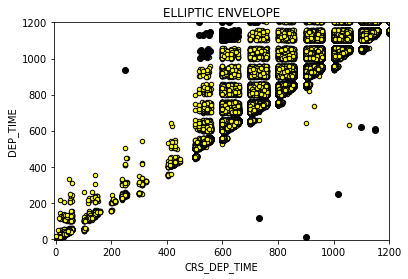

In [ ]:
#detection1#EE
from sklearn.covariance import EllipticEnvelope
import numpy as np
import matplotlib.pyplot as plt


clf = EllipticEnvelope(contamination=.01,random_state=0)
clf.fit(detection1)
ee_scores = pd.Series(clf.decision_function(detection1)) 
detection1['anomaly33'] = pd.Series(clf.predict(detection1))
detection1['anomaly33'] = detection1['anomaly33'].map( {1: 0, -1: 1} )
detection1['anomaly33'].value_counts()
cmap=np.array(['yellow','black'])
plt.scatter(detection1.iloc[:,0],detection1.iloc[:,1],c='yellow',s=20,edgecolor='k')
X=ee_predict.iloc[:,0]
Y=ee_predict.iloc[:,1]
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.scatter(X,Y,c='black')
plt.xlabel('CRS_DEP_TIME')
plt.ylabel('DEP_TIME')
plt.title('ELLIPTIC ENVELOPE')
plt.show()

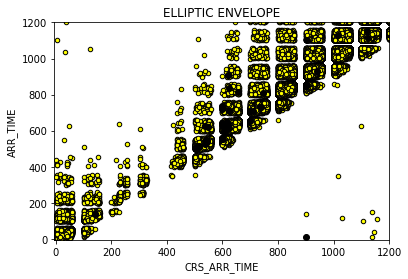

In [ ]:
#detection2#EE
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=.01,random_state=0)
clf.fit(detection2)
ee_scores = pd.Series(clf.decision_function(detection2)) 
detection2['anomaly33'] = pd.Series(clf.predict(detection2))
detection2['anomaly33'] = detection2['anomaly33'].map( {1: 0, -1: 1} )
detection2['anomaly33'].value_counts()
cmap=np.array(['yellow','black'])
plt.scatter(detection2.iloc[:,0],detection2.iloc[:,1],c='yellow',s=20,edgecolor='k')
X=ee_predict.iloc[:,0]
Y=ee_predict.iloc[:,1]
plt.scatter(X,Y,c='black')
plt.xlim((-5, 1200))
plt.ylim((-5, 1200))
plt.xlabel('CRS_ARR_TIME')
plt.ylabel('ARR_TIME')
plt.title('ELLIPTIC ENVELOPE')
plt.show()

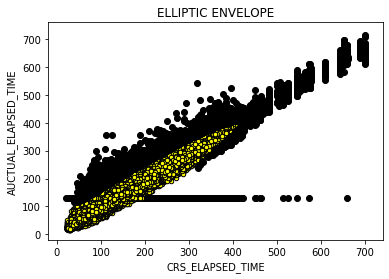

In [ ]:
from sklearn.covariance import EllipticEnvelope


clf = EllipticEnvelope(contamination=.01,random_state=0)
clf.fit(detection3)
ee_scores = pd.Series(clf.decision_function(detection3)) 
detection3['anomaly33'] = pd.Series(clf.predict(detection3))
detection3['anomaly33'] = detection3['anomaly33'].map( {1: 0, -1: 1} )
detection3['anomaly33'].value_counts()
cmap=np.array(['yellow','black'])
plt.scatter(detection3.iloc[:,0],detection3.iloc[:,1],c='yellow',s=20,edgecolor='k')
X=ee_predict.iloc[:,0]
Y=ee_predict.iloc[:,1]
plt.scatter(X,Y,c='black')
plt.xlabel('CRS_ELAPSED_TIME')
plt.ylabel('AUCTUAL_ELAPSED_TIME')
plt.title('ELLIPTIC ENVELOPE')import numpy as np
plt.show()

In [ ]:
import numpy as np
e1 = (detection1['DEP_TIME'] >= detection1['DEP_TIME'].quantile(0.98)) 
e2 = (detection1['CRS_DEP_TIME_Mean'] >= detection1['CRS_DEP_TIME_Mean'].quantile(0.98))
e3 = (detection2['ARR_TIME'] >= detection2['ARR_TIME'].quantile(0.98)) 
e4 = (detection2['CRS_ARR_TIME_Mean'] >= detection2['CRS_ARR_TIME_Mean'].quantile(0.98))
e5 = (detection3['ACTUAL_ELAPSED_TIME_Mean'] >= detection3['ACTUAL_ELAPSED_TIME_Mean'].quantile(0.98)) 
e6 = (detection3['CRS_ELAPSED_TIME'] >= detection3['CRS_ELAPSED_TIME'].quantile(0.98))
detection1['anomaly_manual'] = (e1 | e2).astype(np.int)
detection2['anomaly_manual'] = (e3 | e4).astype(np.int)
detection3['anomaly_manual'] = (e5 | e6).astype(np.int)

In [ ]:
f1_ee = f1_score(detection1['anomaly_manual'],detection1['anomaly33'])
acc_ee = accuracy_score(detection1['anomaly_manual'],detection1['anomaly33'])
roc_ee = roc_auc_score(detection1['anomaly_manual'],detection1['anomaly33'])
pre_ee = precision_score(detection1['anomaly_manual'],detection1['anomaly33'])
sen_ee, spec_ee = get_sensitivity_specificity(detection1['anomaly_manual'],detection1['anomaly33'])
met_ee = {
           'f1_score': f1_ee,
           'accuracy': acc_ee,
           'precision':pre_ee,
           'roc_score': roc_ee,
           'sensitivity': sen_ee,
           'specificity': spec_ee
}


f1_ee = f1_score(detection2['anomaly_manual'],detection2['anomaly33'])
acc_ee = accuracy_score(detection2['anomaly_manual'],detection2['anomaly33'])
roc_ee = roc_auc_score(detection2['anomaly_manual'],detection2['anomaly33'])
pre_ee = precision_score(detection2['anomaly_manual'],detection2['anomaly33'])
sen_ee, spec_ee = get_sensitivity_specificity(detection2['anomaly_manual'],detection2['anomaly33'])
met_ee2 = {
           'f1_score': f1_ee,
           'accuracy': acc_ee,
           'precision':pre_ee,
           'roc_score': roc_ee,
           'sensitivity': sen_ee,
           'specificity': spec_ee
}
f1_ee = f1_score(detection3['anomaly_manual'],detection3['anomaly33'])
acc_ee = accuracy_score(detection3['anomaly_manual'],detection3['anomaly33'])
roc_ee = roc_auc_score(detection3['anomaly_manual'],detection3['anomaly33'])
pre_ee = precision_score(detection3['anomaly_manual'],detection3['anomaly33'])
sen_ee, spec_ee = get_sensitivity_specificity(detection3['anomaly_manual'],detection3['anomaly33'])
met_ee3 = {
           'f1_score': f1_ee,
           'accuracy': acc_ee,
           'precision':pre_ee,
           'roc_score': roc_ee,
           'sensitivity': sen_ee,
           'specificity': spec_ee
}


In [ ]:
metrics = {'detection1': met_ee,
           'detection2': met_ee2,
           'detection3': met_ee3
           
           }
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

,detection1,detection2,detection3
f1_score,0.070021,0.295815,0.227174
accuracy,0.966866,0.973252,0.974435
precision,0.124869,0.562011,0.375739
roc_score,0.519840,0.598116,0.578206
sensitivity,0.975362,0.977405,0.980482
specificity,0.124869,0.562011,0.375739


In [ ]:
outlier_fraction = 0.028
model =  OneClassSVM(nu=outlier_fraction,  degree=2, kernel='rbf')
data = detection3.loc[detection3.ACTUAL_ELAPSED_TIME_Mean <=detection3.ACTUAL_ELAPSED_TIME_Mean.quantile(1-outlier_fraction)]
model.fit(data)

outlier_fraction = 0.028
model =  OneClassSVM(nu=outlier_fraction,  degree=2, kernel='rbf')
data = detection2.loc[detection2.ARR_TIME <=detection2.CRS_ARR_TIME_Mean.quantile(1-outlier_fraction)]
model.fit(data)

outlier_fraction = 0.028
model =  OneClassSVM(nu=outlier_fraction,  degree=2, kernel='rbf')
data = detection1.loc[detection1.DEP_TIME <=detection1.CRS_DEP_TIME_Mean.quantile(1-outlier_fraction)]
model.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.028, shrinking=True, tol=0.001, verbose=False)

In [ ]:
detection3['anomaly_svm'] = pd.Series(model.predict(detection3))
detection3['anomaly_svm'] = detection3['anomaly_svm'].map( {1: 0, -1: 1} )

detection2['anomaly_svm'] = pd.Series(model.predict(detection2))
detection2['anomaly_svm'] = detection3['anomaly_svm'].map( {1: 0, -1: 1} )


detection1['anomaly_svm'] = pd.Series(model.predict(detection1))
detection1['anomaly_svm'] = detection1['anomaly_svm'].map( {1: 0, -1: 1} )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
p1 = (detection1['DEP_TIME'] >= detection1['DEP_TIME'].quantile(0.98)) 
p2 = (detection1['CRS_DEP_TIME_Mean'] >= detection1['CRS_DEP_TIME_Mean'].quantile(0.98))
p3 = (detection2['ARR_TIME'] >= detection2['ARR_TIME'].quantile(0.98)) 
p4 = (detection2['CRS_ARR_TIME_Mean'] >= detection2['CRS_ARR_TIME_Mean'].quantile(0.98))
p5 = (detection3['ACTUAL_ELAPSED_TIME_Mean'] >= detection3['ACTUAL_ELAPSED_TIME_Mean'].quantile(0.98)) 
p6 = (detection3['CRS_ELAPSED_TIME'] >= detection3['CRS_ELAPSED_TIME'].quantile(0.98))

detection1['anomaly_manual'] = (p1 | p2).astype(np.int)
detection2['anomaly_manual'] = (p3 | p4).astype(np.int)
detection3['anomaly_manual'] = (p5 | p6).astype(np.int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
detection3['anomaly_manual'] = detection3['anomaly_manual'].fillna(0)
detection3['anomaly_svm'] = detection3['anomaly_svm'].fillna(0)
acc_svm = accuracy_score(detection3['anomaly_manual'],detection3['anomaly_svm'])
met_svm = {
           'accuracy': acc_svm
           
          }

detection2['anomaly_manual'] = detection2['anomaly_manual'].fillna(0)
detection2['anomaly_svm'] = detection2['anomaly_svm'].fillna(0)
acc_svm2 = accuracy_score(detection2['anomaly_manual'],detection2['anomaly_svm'])
met_svm2 = {
           
           'accuracy': acc_svm2
           
          }


detection1['anomaly_manual'] = detection1['anomaly_manual'].fillna(0)
detection1['anomaly_svm'] = detection1['anomaly_svm'].fillna(0)

acc_svm3 = accuracy_score(detection1['anomaly_manual'],detection1['anomaly_svm'])
met_svm3 = {
          
           'accuracy': acc_svm3
          }

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
metrics = {'detection2': met_svm2,
           'detection1': met_svm3
          }
metrics_df = pd.DataFrame.from_dict(metrics)

metrics_df

,detection2,detection1
accuracy,0.971979,0.921138


Estimated number of anomalies: 28750


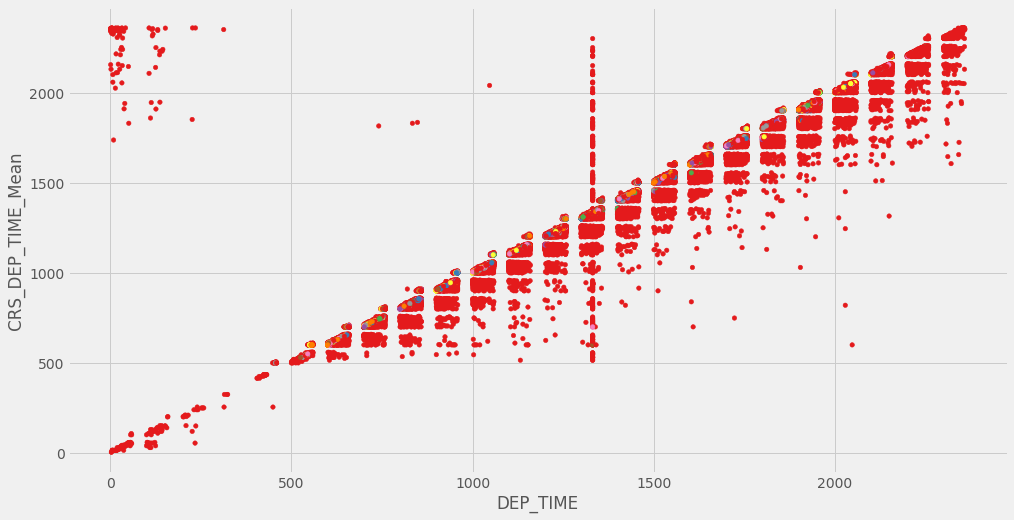

In [ ]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps = .2, metric="euclidean", min_samples = 5,n_jobs = -1)
clusters = outlier_detection.fit_predict(detection1)
from matplotlib import cm
cmap = cm.get_cmap('Set1')
detection1.plot.scatter(x='DEP_TIME',y='CRS_DEP_TIME_Mean', c=clusters, cmap=cmap,colorbar = False)
n_noise_ = list(clusters).count(-1)
print('Estimated number of anomalies: %d' % n_noise_)

Estimated number of anomalies: 43917


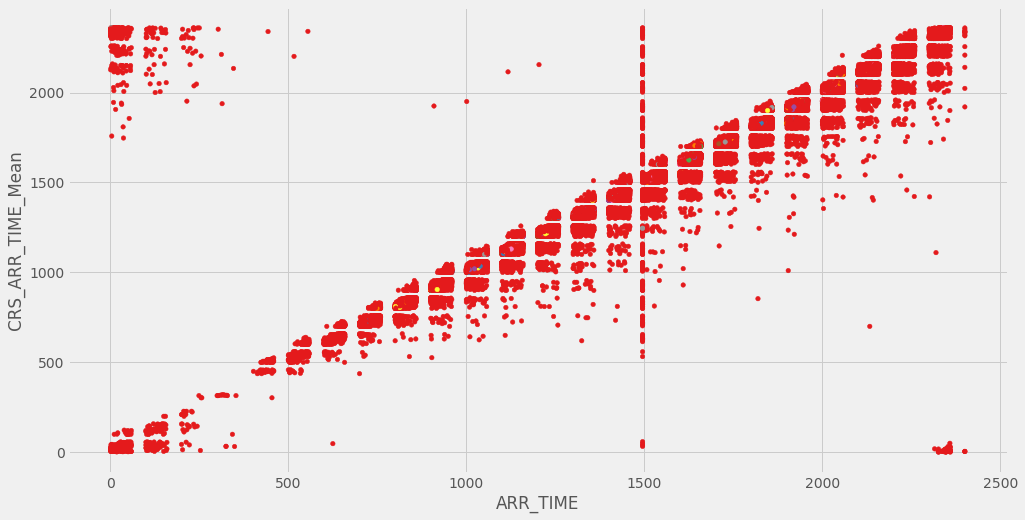

In [ ]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps = .2, metric="euclidean", min_samples = 5,n_jobs = -1)
clusters = outlier_detection.fit_predict(detection2)
from matplotlib import cm
cmap = cm.get_cmap('Set1')
detection2.plot.scatter(x='ARR_TIME',y='CRS_ARR_TIME_Mean', c=clusters, cmap=cmap,colorbar = False)
n_noise_ = list(clusters).count(-1)
print('Estimated number of anomalies: %d' % n_noise_)

Estimated number of anomalies: 16997


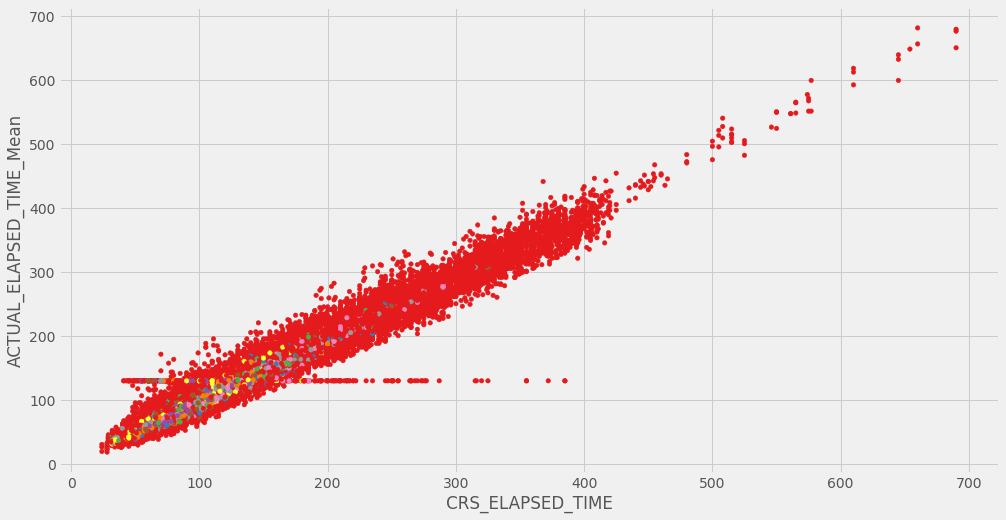

In [ ]:
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(eps = .2, metric="euclidean", min_samples = 5,n_jobs = -1)
clusters = outlier_detection.fit_predict(detection3)
from matplotlib import cm
cmap = cm.get_cmap('Set1')
detection3.plot.scatter(x='CRS_ELAPSED_TIME',y='ACTUAL_ELAPSED_TIME_Mean', c=clusters, cmap=cmap,colorbar = False)
n_noise_ = list(clusters).count(-1)
print('Estimated number of anomalies: %d' % n_noise_)

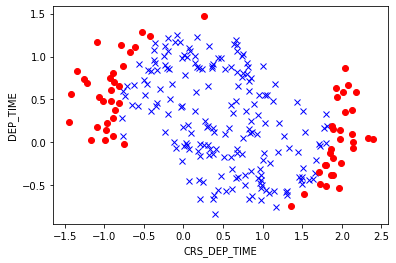

In [ ]:
#oneclasssvm#detection1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import OneClassSVM
oc = OneClassSVM(nu=0.25, gamma=0.05)
oc.fit(detection1)
pred = oc.predict(detection1)
# inliers are labeled 1, outliers are labeled -1
normal = detection1[pred == 1]
abnormal = detection1[pred == -1]
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('CRS_DEP_TIME')
plt.ylabel('DEP_TIME')
plt.show()

In [ ]:
#oneclasssvm#detection2
from sklearn.svm import OneClassSVM
oc = OneClassSVM(nu=0.25, gamma=0.05)
oc.fit(detection2)
pred = oc.predict(detection2)

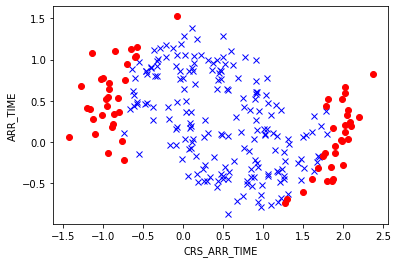

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# inliers are labeled 1, outliers are labeled -1
normal = detection2[pred == 1]
abnormal = detection2[pred == -1]
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('CRS_ARR_TIME')
plt.ylabel('ARR_TIME')
plt.show()

In [ ]:
#oneclasssvm#detection3
from sklearn.svm import OneClassSVM
oc = OneClassSVM(nu=0.25, gamma=0.05)
oc.fit(detection3)
pred = oc.predict(detection3)

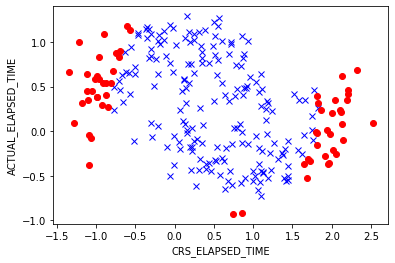

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# inliers are labeled 1, outliers are labeled -1
normal = detection3[pred == 1]
abnormal = detection3[pred == -1]
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('CRS_ELAPSED_TIME')
plt.ylabel('ACTUAL_ELAPSED_TIME')
plt.show()